In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from CASutils import mapplot_utils as mymaps
from CASutils import calendar_utils as cal
from CASutils import colorbar_utils as cbars
from CASutils import averaging_utils as avg
from CASutils import plothisto_utils as histo
from CASutils import bootstrap_utils as boot
import cartopy.crs as ccrs
import sys

from math import nan

import importlib
importlib.reload(histo)

<module 'CASutils.plothisto_utils' from '/home/islas/python/CASanalysis/CASutils/plothisto_utils.py'>

In [2]:
plotpath="/project/cas/islas/python_plots/CAM7_vertres_paper/FIGURES/SUPP/"

In [3]:
# compositing westerly and easterly QBO.
# defining the QBO phase based on the anomalies from the climatological average
# westerly QBO is where the qbo winds are greater than 0.5 times the interannual standard deviation
# easterly QBO is where the qbo winds are less than -0.5 times the interannual standard deviation
def composite_w_e(qbo,olr, timevar='year', signifcalc=True):
    qbo = qbo - qbo.mean(timevar) # calculate anomalies from climatology
    olr = olr - olr.mean(timevar)
    
    def compute_signif(w, e):
        allevals=[] ; allwvals=[]
        try:
            nmems = w.M.size
            multimem=True
        except:
            multimem=False
            
        if (multimem == True):
            for imem in np.arange(0,w.M.size,1):
                wvals = w.isel(M=imem)
                wvals = wvals.dropna(dim=timevar)
                allwvals.append(wvals)
                evals = e.isel(M=imem)
                evals = evals.dropna(dim=timevar)
                evals = evals.dropna(dim=timevar)
                allevals.append(evals)
            allevals = xr.concat(allevals, dim='year')
            allwvals = xr.concat(allwvals, dim='year')
        else:
            allevals = e.dropna(dim=timevar)
            allwvals = w.dropna(dim=timevar)
            
        signif = boot.bootdif2means(allevals, allwvals)
        return signif    
    
    qbo_w = qbo.where( qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_w')
    qbo_e = qbo.where( qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_e')

    olr_w = olr.where( qbo > 0.5*qbo.std(timevar), nan)
    olr_e = olr.where( qbo < -0.5*qbo.std(timevar), nan)
    if (signifcalc):
        signif = compute_signif(olr_w, olr_e)
        signif = signif.rename('signif')
        
    olr_w = olr_w.mean(timevar, skipna=True).rename('olr_w')
    olr_e = olr_e.mean(timevar, skipna=True).rename('olr_e')
    
    if (signifcalc):
        datout = xr.merge([qbo_w, qbo_e, olr_w, olr_e, signif])
    else:
        datout = xr.merge([qbo_w, qbo_e, olr_w, olr_e])
    
    #test4nans = olr.mean(timevar, skipna=False)
    #datout = datout.where( ~np.isnan(test4nans), nan)
    return datout

### Read in the ERA5 data

In [5]:
#era5_olr = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OLR/FLUT_mjo_ERA5.nc")
#era5_u = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/mon/ERA5.nc")
#era5_u['plev'] = era5_u.plev/100.

In [7]:
#era5_mjo_std = era5_olr.MJO_OLR.std('time').load()
#era5_qbo = avg.cosweightlat(era5_u.uzm, -5, 5).load()
#era5_qbo = era5_qbo.interp(plev=50.)
#era5_qbo = cal.season_ts(era5_qbo, 'DJF')
#era5_qbo = era5_qbo.rename({'time':'year'})
#era5_qbo['year'] = era5_qbo.year.dt.year-1

DataArrayWeighted with weights along dimensions: lat


In [15]:
era5

<xarray.Dataset> Size: 712B
Dimensions:  (year: 44)
Coordinates:
    plev     float64 8B ...
  * year     (year) int64 352B 1979 1980 1981 1982 1983 ... 2019 2020 2021 2022
Data variables:
    UQBO     (year) float64 352B ...

In [16]:
era5 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OLR/FLUT_mjo_ERA5.nc")
era5_mjo_std = era5.MJO_OLR.std('time').load()

### Read in the MERRA2 data

In [8]:
merra2 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OLR/OLR_mjo_MERRA2.nc")
merra2_mjo_std = merra2.MJO_OLR.std('time').load()

### Read in the JRA55 data

In [10]:
jra55 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OLR/OLR_mjo_JRA55.nc")
jra55_mjo_std = jra55.MJO_OLR.std('time').load()

### Read in the model data

In [11]:
basepath="/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OLR/"
allmems_b=[]
nmems=3
for imem in np.arange(1,nmems+1,1):
    memstr=str(imem).zfill(3)
    dat = xr.open_dataset(basepath+"BHIST_BSSP_MJO_OLR_1850_2100_"+memstr+".nc").sel(lat=slice(-35,35))
    allmems_b.append(dat)
mems = xr.DataArray(np.arange(1,nmems+1,1), coords=[np.arange(1,nmems+1,1)], dims=['M'])
allmems_b = xr.concat(allmems_b, dim=mems)

allmems_f=[]
for imem in np.arange(1,nmems+1,1):
    memstr = str(imem).zfill(3)
    dat = xr.open_dataset(basepath+'MJO_OLR_FL83_1979_2015_'+memstr+'.nc').sel(lat=slice(-35,35))
    allmems_f.append(dat)
mems = xr.DataArray(np.arange(1,nmems+1,1), coords=[np.arange(1,nmems+1,1)], dims=['M'])
allmems_f = xr.concat(allmems_f, dim=mems)

In [12]:
l83b_mjo_std = allmems_b.MJO_OLR.std('time').load()
l83b_qbo = avg.cosweightlat(allmems_b.Uzm, -5, 5).load()
l83b_qbo = l83b_qbo.interp(ilev=50.)

l83f_mjo_std = allmems_f.MJO_OLR.std('time').load()
l83f_qbo = avg.cosweightlat(allmems_f.Uzm, -5, 5).load()
l83f_qbo = l83f_qbo.interp(ilev=50.)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


### Reanalysis composite 

In [17]:
era5_composite = composite_w_e(era5.UQBO, era5_mjo_std)
merra2_composite = composite_w_e(merra2.UQBO, merra2_mjo_std)
jra55_composite = composite_w_e(jra55.UQBO, jra55_mjo_std)

you are using an xarray dataarray
you are using an xarray dataarray
you are using an xarray dataarray
you are using an xarray dataarray
you are using an xarray dataarray
you are using an xarray dataarray


### Model composite from 1979 to 2023

In [18]:
modelb_1979_2023 = composite_w_e(l83b_qbo.sel(year=slice(1979,2023)), l83b_mjo_std.sel(year=slice(1979,2023)))
modelf_1979_2020 = composite_w_e(l83f_qbo.sel(year=slice(1979,2020)), l83f_mjo_std.sel(year=slice(1979,2020)))

you are using an xarray dataarray
you are using an xarray dataarray
you are using an xarray dataarray
you are using an xarray dataarray


### Model running 45 year composites

In [19]:
modelb_segs_mjo = l83b_mjo_std.rolling(year=45, min_periods=45, center=True)
modelb_segs_mjo = modelb_segs_mjo.construct('segtime')
modelb_segs_qbo = l83b_qbo.rolling(year=45, min_periods=45, center=True)
modelb_segs_qbo = modelb_segs_qbo.construct('segtime')
check4nans = modelb_segs_mjo.mean('segtime', skipna=False)
modelb_segs_mjo = modelb_segs_mjo.where( ~np.isnan(check4nans), drop=True)
check4nans = modelb_segs_qbo.mean('segtime', skipna=False)
modelb_segs_qbo = modelb_segs_qbo.where( ~np.isnan(check4nans), drop=True)
modelb_running_45y = composite_w_e(modelb_segs_qbo, modelb_segs_mjo, timevar='segtime', signifcalc=False)

#modelf_segs_mjo = l83f_mjo_std.rolling(year=45, min_periods=45, center=True)
#modelf_segs_mjo = modelf_segs_mjo.construct('segtime')
#modelf_segs_qbo = l83f_qbo.rolling(year=45, min_periods=45)
#modelf_segs_qbo = modelf_segs_qbo.construct('segtime')
#modelf_running_45y = composite_w_e(modelf_segs_qbo, modelf_segs_mjo, timevar='segtime')

In [30]:
modelb_running_45y

<xarray.Dataset> Size: 211MB
Dimensions:  (year: 206, M: 3, lat: 74, lon: 288)
Coordinates:
  * year     (year) int64 2kB 1873 1874 1875 1876 1877 ... 2075 2076 2077 2078
    zlon     float64 8B 0.0
  * M        (M) int64 24B 1 2 3
    ilev     float64 8B 50.0
  * lat      (lat) float64 592B -34.4 -33.46 -32.51 -31.57 ... 32.51 33.46 34.4
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    u_w      (M, year) float64 5kB 10.04 10.12 9.645 9.912 ... 4.353 4.415 4.327
    u_e      (M, year) float64 5kB -13.74 -13.37 -13.69 ... -9.379 -9.211 -9.292
    olr_w    (M, year, lat, lon) float64 105MB 0.1969 0.1806 ... -0.06503
    olr_e    (M, year, lat, lon) float64 105MB -0.1985 -0.1758 ... -0.877

In [20]:
modelb_running_45y_avg = avg.cosweightlonlat(modelb_running_45y.olr_e - modelb_running_45y.olr_w, 50, 170, -20, 5)
modelf_avg = avg.cosweightlonlat(modelf_1979_2020.olr_e - modelf_1979_2020.olr_w, 50, 170, -20, 5)

In [21]:
era5_1979_2023_avg = avg.cosweightlonlat(era5_composite.olr_e - era5_composite.olr_w, 50, 170, -20, 5)
merra2_1980_2023_avg = avg.cosweightlonlat(merra2_composite.olr_e - merra2_composite.olr_w, 50, 170, -20, 5)
jra55_1979_2023_avg = avg.cosweightlonlat(jra55_composite.olr_e - jra55_composite.olr_w, 50, 170, -20, 5)

flipping longitudes


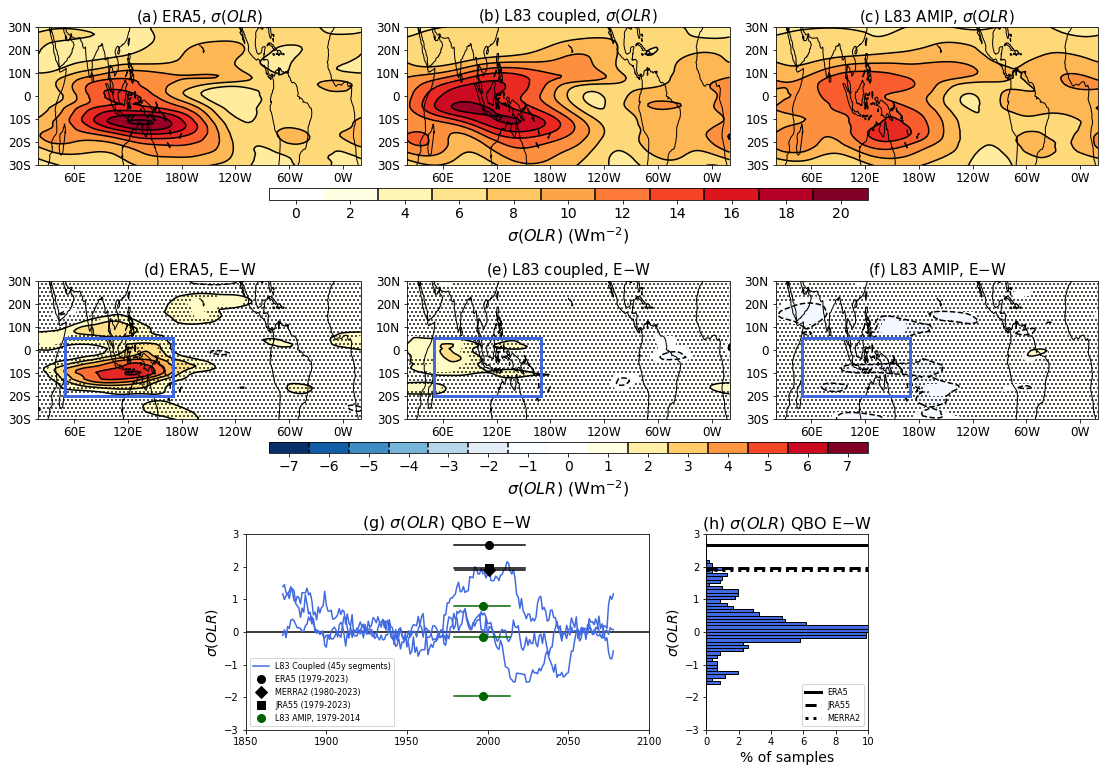

In [22]:
fig = plt.figure(figsize=(16,16))

ci=2 ; cmax=20

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, era5_mjo_std.mean(['year']), era5_mjo_std.lon, era5_mjo_std.lat,
                                                   ci, -1.*cmax, cmax,'(a) ERA5, $\sigma(OLR)$',
                                                   0.02,0.3,0.85,0.97, contourlines=True)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83b_mjo_std.mean(['year','M']), l83b_mjo_std.lon, l83b_mjo_std.lat,
                                                    ci, -1.*cmax, cmax,'(b) L83 coupled, $\sigma(OLR)$',
                                                   0.34,0.62,0.85,0.97, contourlines=True)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83f_mjo_std.mean(['year','M']), l83f_mjo_std.lon, l83f_mjo_std.lat,
                                                  ci, -1.*cmax,cmax, '(c) L83 AMIP, $\sigma(OLR)$',
                                                  0.66,0.94,0.85,0.97, contourlines=True)

ax = cbars.plotcolorbar(fig, 2, -20, 20, '$\sigma(OLR)$ (Wm$^{-2}$)',
                        0.22,0.74,0.82,0.83, posneg='pos', contourlines=True,
                        ticks=[0,2,4,6,8,10,12,14,16,18,20])


ci=1 ; cmax=7
                                                   
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, era5_composite.olr_e - era5_composite.olr_w, 
                                                   era5_composite.lon, era5_composite.lat,
                                                   ci, -1.*cmax, cmax,'(d) ERA5, E$-$W',0.02,0.3,0.63,0.75, contourlines=True,
                                                  signifdat = era5_composite.signif, stipplesignif=True)

ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, modelb_1979_2023.olr_e.mean('M') - modelb_1979_2023.olr_w.mean('M'),
                                                   modelb_1979_2023.lon, modelb_1979_2023.lat,
                                                   ci, -1.*cmax, cmax, '(e) L83 coupled, E$-$W',0.34,0.62,0.63,0.75, contourlines=True,
                                                  signifdat = modelb_1979_2023.signif, stipplesignif=True)

ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, modelf_1979_2020.olr_e.mean('M') - modelf_1979_2020.olr_w.mean('M'),
                                                   modelf_1979_2020.lon, modelf_1979_2020.lat,
                                                   ci, -1.*cmax, cmax, '(f) L83 AMIP, E$-$W',0.66,0.94,0.63,0.75, contourlines=True,
                                                  signifdat = modelf_1979_2020.signif, stipplesignif=True)

ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)

ax = cbars.plotcolorbar(fig, 1, -7, 7, '$\sigma(OLR)$ (Wm$^{-2}$)',
                        0.22,0.74,0.6,0.61, contourlines=True,
                       ticks=[-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7])


ax = fig.add_axes([0.2,0.36,0.35,0.17])
ax.set_ylim(-3,3)
ax.set_xlim(1850,2100)
ax.set_title('(g) $\sigma(OLR)$ QBO E$-$W', fontsize=16)
ax.set_ylabel('$\sigma(OLR)$', fontsize=14)
ax.plot([1850,2100],[0,0], color='black')

ax.plot(modelb_running_45y_avg.year, modelb_running_45y_avg.isel(M=0), color='royalblue', 
       label='L83 Coupled (45y segments)')
ax.plot(modelb_running_45y_avg.year, modelb_running_45y_avg.isel(M=1), color='royalblue')
ax.plot(modelb_running_45y_avg.year, modelb_running_45y_avg.isel(M=2), color='royalblue')

ax.plot([1979,2023],[era5_1979_2023_avg, era5_1979_2023_avg], color='black')
ax.plot(2001, era5_1979_2023_avg, "o", color='black', markersize=8, label='ERA5 (1979-2023)')

ax.plot([1980,2023],[merra2_1980_2023_avg, merra2_1980_2023_avg], color='black')
ax.plot(2001, merra2_1980_2023_avg,"D", color='black', markersize=8, label='MERRA2 (1980-2023)')

ax.plot([1979,2023],[jra55_1979_2023_avg, jra55_1979_2023_avg], color='black')
ax.plot(2001, jra55_1979_2023_avg,"s", color='black', markersize=8, label='JRA55 (1979-2023)')


ax.plot(np.arange(0,3,1)*0 + 1997, modelf_avg, "o", color='darkgreen', markersize=8, label='L83 AMIP, 1979-2014')
ax.plot([1979,2014], [modelf_avg.isel(M=0), modelf_avg.isel(M=0)], color='darkgreen')
ax.plot([1979,2014], [modelf_avg.isel(M=1), modelf_avg.isel(M=1)], color='darkgreen')
ax.plot([1979,2014], [modelf_avg.isel(M=2), modelf_avg.isel(M=2)], color='darkgreen')

ax.legend(loc='lower left', fontsize=8)


modelb_anoms = modelb_running_45y_avg
modelb_anoms_stack = modelb_anoms.stack(z=("M","year"))
modelb_anoms_stack = modelb_anoms_stack.dropna('z')

ax = histo.plothisto(fig, modelb_anoms_stack, np.arange(-3,3,0.1), 0.6,0.74,0.36, 0.53, orient='vertical', color='royalblue', 
                    percent=True, xlim=(0,10), ylim=(-3,3), ytitle="$\sigma(OLR)$",
                    xtitle="% of samples", title='(h) $\sigma(OLR)$ QBO E$-$W')

ax.plot([0,10],[0,0], color='black', zorder=0)
ax.plot([0,10],[era5_1979_2023_avg, era5_1979_2023_avg],
        color='black', linewidth=3, label='ERA5')
#ax.text(9.8,2.5,'ERA5', ha='right', va='top', color='black')

ax.plot([0,10],[jra55_1979_2023_avg, jra55_1979_2023_avg],
        color='black', linestyle='dashed', linewidth=3, label='JRA55')

ax.plot([0,10],[merra2_1980_2023_avg, merra2_1980_2023_avg],
        color='black', linestyle='dotted', linewidth=3, label='MERRA2')

ax.legend(loc='lower right', fontsize=8)


fig.savefig(plotpath+'figS9.pdf', bbox_inches='tight', facecolor='white')